In [2]:
# Sentence Embedding MiniLM

# pip install transformers sentence-transformers
import json
import torch
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import pandas as pd

print("✅ Libraries imported successfully.")

# Load the Quranic data
print("📥 Loading Quranic data from 'unified_quran_data.json'...")
with open("data/unified_quran_data.json", "r", encoding="utf-8") as f:
    quran_data = json.load(f)

print(f"✅ Loaded {len(quran_data)} verses.")

# Prepare text and metadata
print("🧾 Preparing verse texts and metadata...")
verses_texts = []
verse_meta = []

for verse in quran_data:
    text = verse['text']
    verses_texts.append(text)
    verse_meta.append({
        'surah': verse['surah'],
        'verse': verse['verse'],
        'text': text
    })

print(f"✅ Prepared {len(verses_texts)} verse texts.")

# Load the SentenceTransformer model
print("🧠 Loading SentenceTransformer model: 'paraphrase-multilingual-MiniLM-L12-v2'...")
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
print("✅ Model loaded successfully.")

# Generate sentence embeddings
print("🔄 Generating sentence embeddings...")
embeddings = model.encode(verses_texts, show_progress_bar=True, convert_to_tensor=True)
print("✅ Sentence embeddings generated.")

# Save embeddings and metadata
print("💾 Saving embeddings and metadata...")

verse_df = pd.DataFrame(verse_meta)
verse_df['embedding'] = embeddings.tolist()

# Save to files
verse_df.to_pickle("output/MiniLM/quran_sentence_MiniLM_embeddings.pkl")
verse_df.to_csv("output/MiniLM/quran_sentence_MiniLM_embeddings.csv", index=False)

print("✅ Embeddings and metadata saved to:")
print("   - quran_sentence_MiniLM_embeddings.pkl")
print("   - quran_sentence_MiniLM_embeddings.csv")

# Optional: show final output shape
print(f"📊 Embedding matrix shape: {embeddings.shape}")

✅ Libraries imported successfully.
📥 Loading Quranic data from 'unified_quran_data.json'...
✅ Loaded 6236 verses.
🧾 Preparing verse texts and metadata...
✅ Prepared 6236 verse texts.
🧠 Loading SentenceTransformer model: 'paraphrase-multilingual-MiniLM-L12-v2'...
✅ Model loaded successfully.
🔄 Generating sentence embeddings...


Batches:   0%|          | 0/195 [00:00<?, ?it/s]

✅ Sentence embeddings generated.
💾 Saving embeddings and metadata...
✅ Embeddings and metadata saved to:
   - quran_sentence_MiniLM_embeddings.pkl
   - quran_sentence_MiniLM_embeddings.csv
📊 Embedding matrix shape: torch.Size([6236, 384])


In [3]:
# specific root Configuration
specific_root = "صلح"

In [5]:
# Verse Embedding Extraction

import json
import torch
import pandas as pd

# Load precomputed embeddings and metadata from file
print("📥 Loading precomputed embeddings and metadata from 'quran_sentence_MiniLM_embeddings.pkl'...")
verse_df = pd.read_pickle("output/MiniLM/quran_sentence_MiniLM_embeddings.pkl")
print(f"✅ Loaded embeddings for {len(verse_df)} verses.")

# Load the original Quranic data to retrieve 'arabic_roots'
print("📥 Loading Quranic data from 'unified_quran_data.json'...")
with open("data/unified_quran_data.json", "r", encoding="utf-8") as f:
    quran_data = json.load(f)
print(f"✅ Loaded {len(quran_data)} verses from JSON.")

# Create a DataFrame from the JSON data (keeping relevant fields)
quran_df = pd.DataFrame(quran_data)[['surah', 'verse', 'arabic_roots']]

# Merge the embeddings DataFrame with the Quranic data to add 'arabic_roots'
merged_df = pd.merge(verse_df, quran_df, on=['surah', 'verse'], how='left')
print("✅ Merged embeddings with Arabic roots information.")

# Filter verses that contain the specified root in their 'arabic_roots' field
filtered_df = merged_df[merged_df['arabic_roots'].apply(lambda roots: specific_root in roots if isinstance(roots, list) else False)]
print(f"🔎 Found {len(filtered_df)} verses containing the root '{specific_root}'.")

# Extract the embeddings for the filtered verses and convert to a tensor
filtered_embeddings = torch.tensor(filtered_df['embedding'].tolist())

# Save the filtered DataFrame (which includes metadata and embeddings) for later stages
output_pickle = f"output/MiniLM/{specific_root}_sentence_MiniLM.pkl"
filtered_df.to_pickle(output_pickle)
print(f"💾 Filtered data saved to '{output_pickle}'.")

# Optionally, also save as CSV (note: CSV may not fully preserve embeddings)
output_csv = f"output/MiniLM/{specific_root}_sentence_MiniLM.csv"
filtered_df.to_csv(output_csv, index=False)
print(f"💾 Filtered data saved to '{output_csv}'.")

📥 Loading precomputed embeddings and metadata from 'quran_sentence_MiniLM_embeddings.pkl'...
✅ Loaded embeddings for 6236 verses.
📥 Loading Quranic data from 'unified_quran_data.json'...
✅ Loaded 6236 verses from JSON.
✅ Merged embeddings with Arabic roots information.
🔎 Found 170 verses containing the root 'صلح'.
💾 Filtered data saved to 'output/MiniLM/صلح_sentence_MiniLM.pkl'.
💾 Filtered data saved to 'output/MiniLM/صلح_sentence_MiniLM.csv'.


In [11]:
# Dimension Reduction

import umap
import torch
import pandas as pd

# Load the filtered data with embeddings and metadata
print(f"📥 Loading filtered data from '{specific_root}_sentence_MiniLM.pkl'...")
filtered_df = pd.read_pickle(f"output/minilm/{specific_root}_sentence_MiniLM.pkl")
filtered_embeddings = torch.tensor(filtered_df['embedding'].tolist())
print(f"✅ Loaded filtered data with {filtered_embeddings.shape[0]} verses.")

# Set the default number of dimensions for reduction
num_embeddings = filtered_embeddings.shape[0]
n_components = num_embeddings - 3
print(f"🔻 Reducing dimensions to {n_components} using UMAP...")

# Apply UMAP dimensionality reduction
umap_model = umap.UMAP(n_neighbors=15, n_components=n_components, metric='cosine', random_state=42)
reduced_embeddings = umap_model.fit_transform(filtered_embeddings.cpu())
print("✅ UMAP reduction complete. Reduced embeddings shape:", reduced_embeddings.shape)

# Save the reduced embeddings back into the DataFrame (each row now has a 'reduced_embedding')
filtered_df['reduced_embedding'] = list(reduced_embeddings)

# Save the updated DataFrame for later stages
output_file = f"output/minilm/{specific_root}_sentence_MiniLM_reduced.pkl"
filtered_df.to_pickle(output_file)
print(f"💾 Reduced embeddings and metadata saved to '{output_file}'.")


📥 Loading filtered data from 'صلح_sentence_MiniLM.pkl'...
✅ Loaded filtered data with 170 verses.
🔻 Reducing dimensions to 167 using UMAP...


C:\Users\DiQz\anaconda3\envs\quran_analysis\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\DiQz\anaconda3\envs\quran_analysis\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ UMAP reduction complete. Reduced embeddings shape: (170, 167)
💾 Reduced embeddings and metadata saved to 'output/minilm/صلح_sentence_MiniLM_reduced.pkl'.


📥 Loading reduced data from 'output/minilm/صلح_sentence_MiniLM_reduced.pkl'...
✅ Loaded reduced data for 170 verses.
✅ Extracted embeddings array with shape: (170, 167)


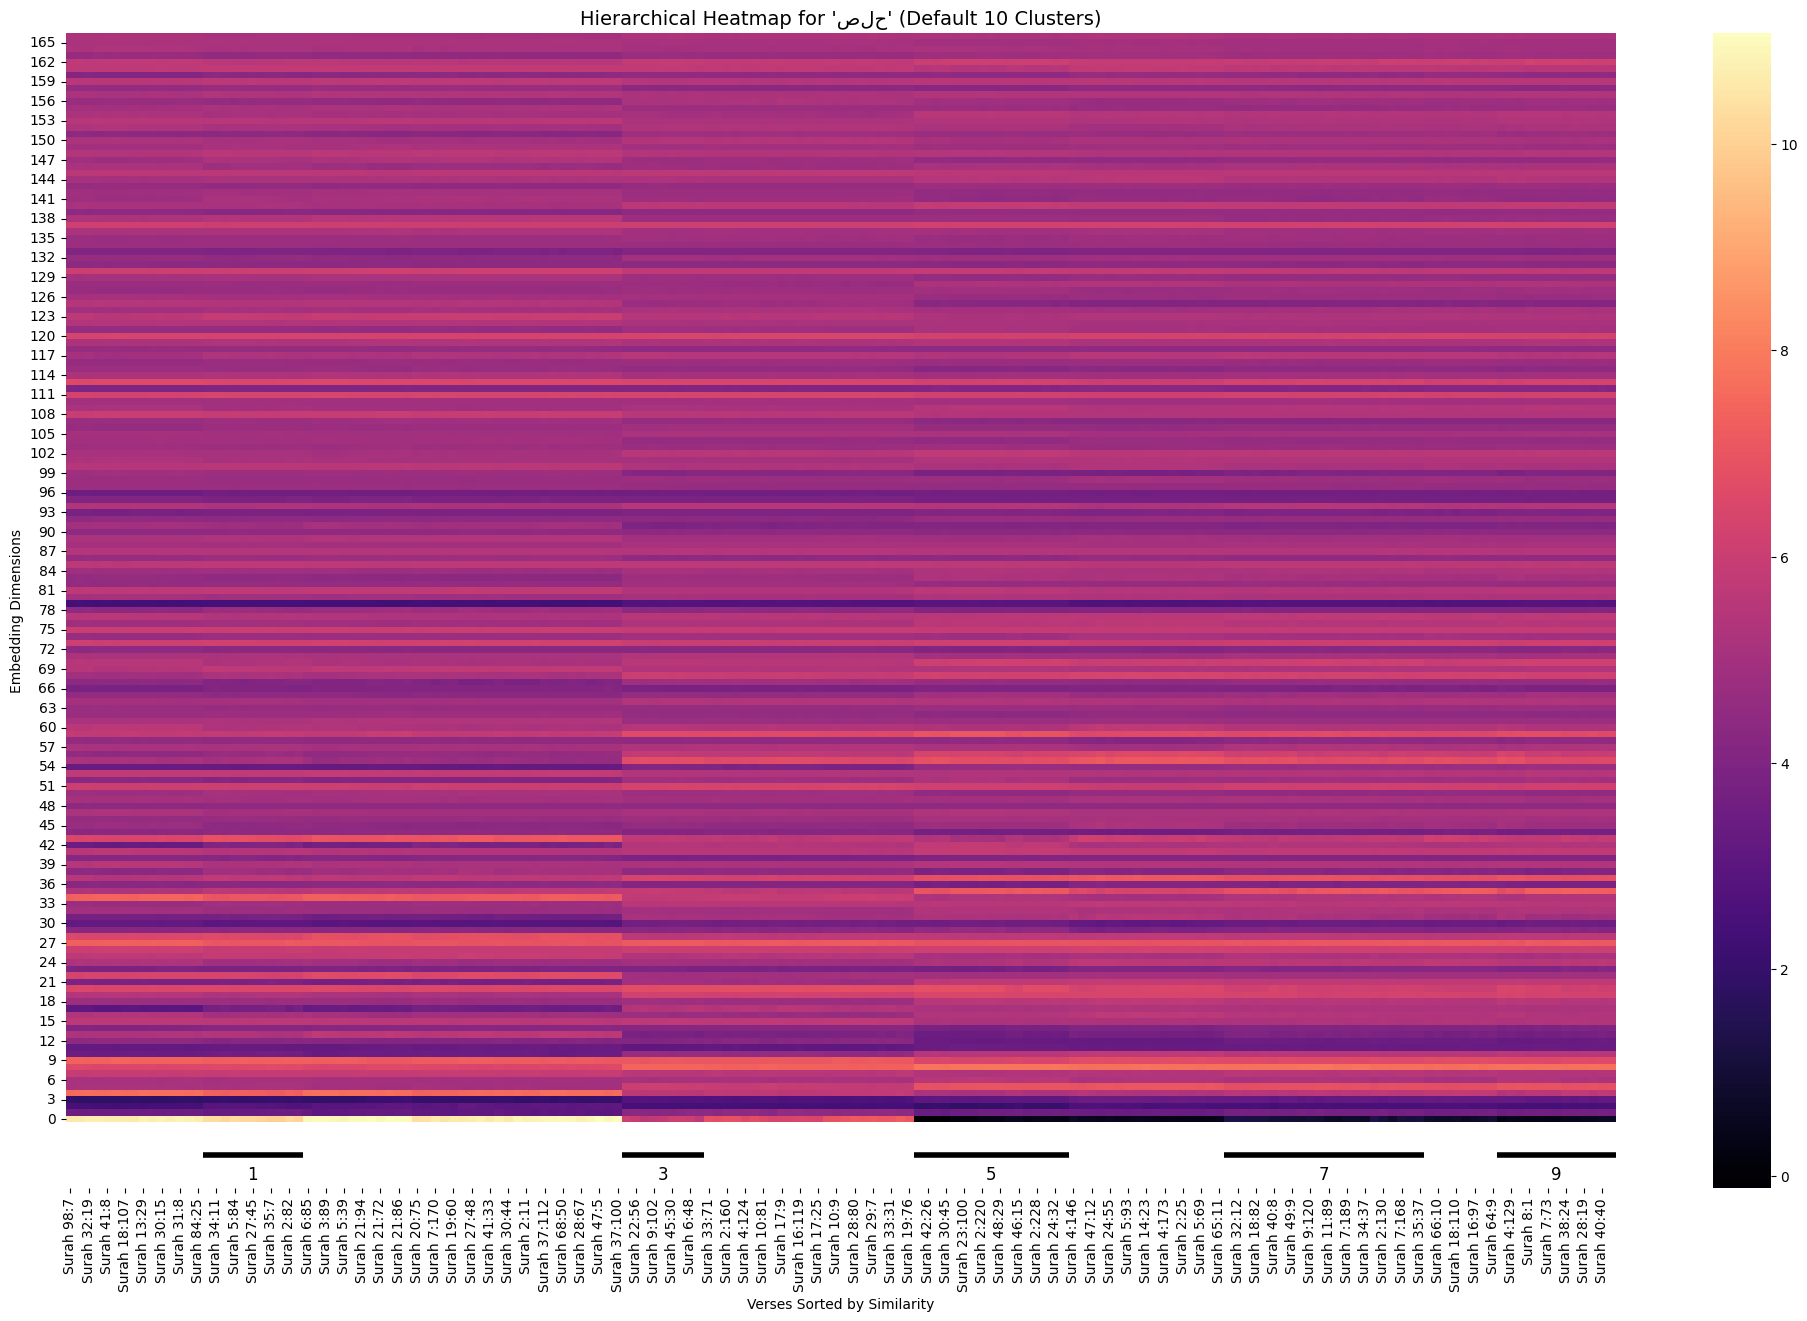

Enter desired number of clusters based on the above visualization (press Enter to keep default of 10):  20


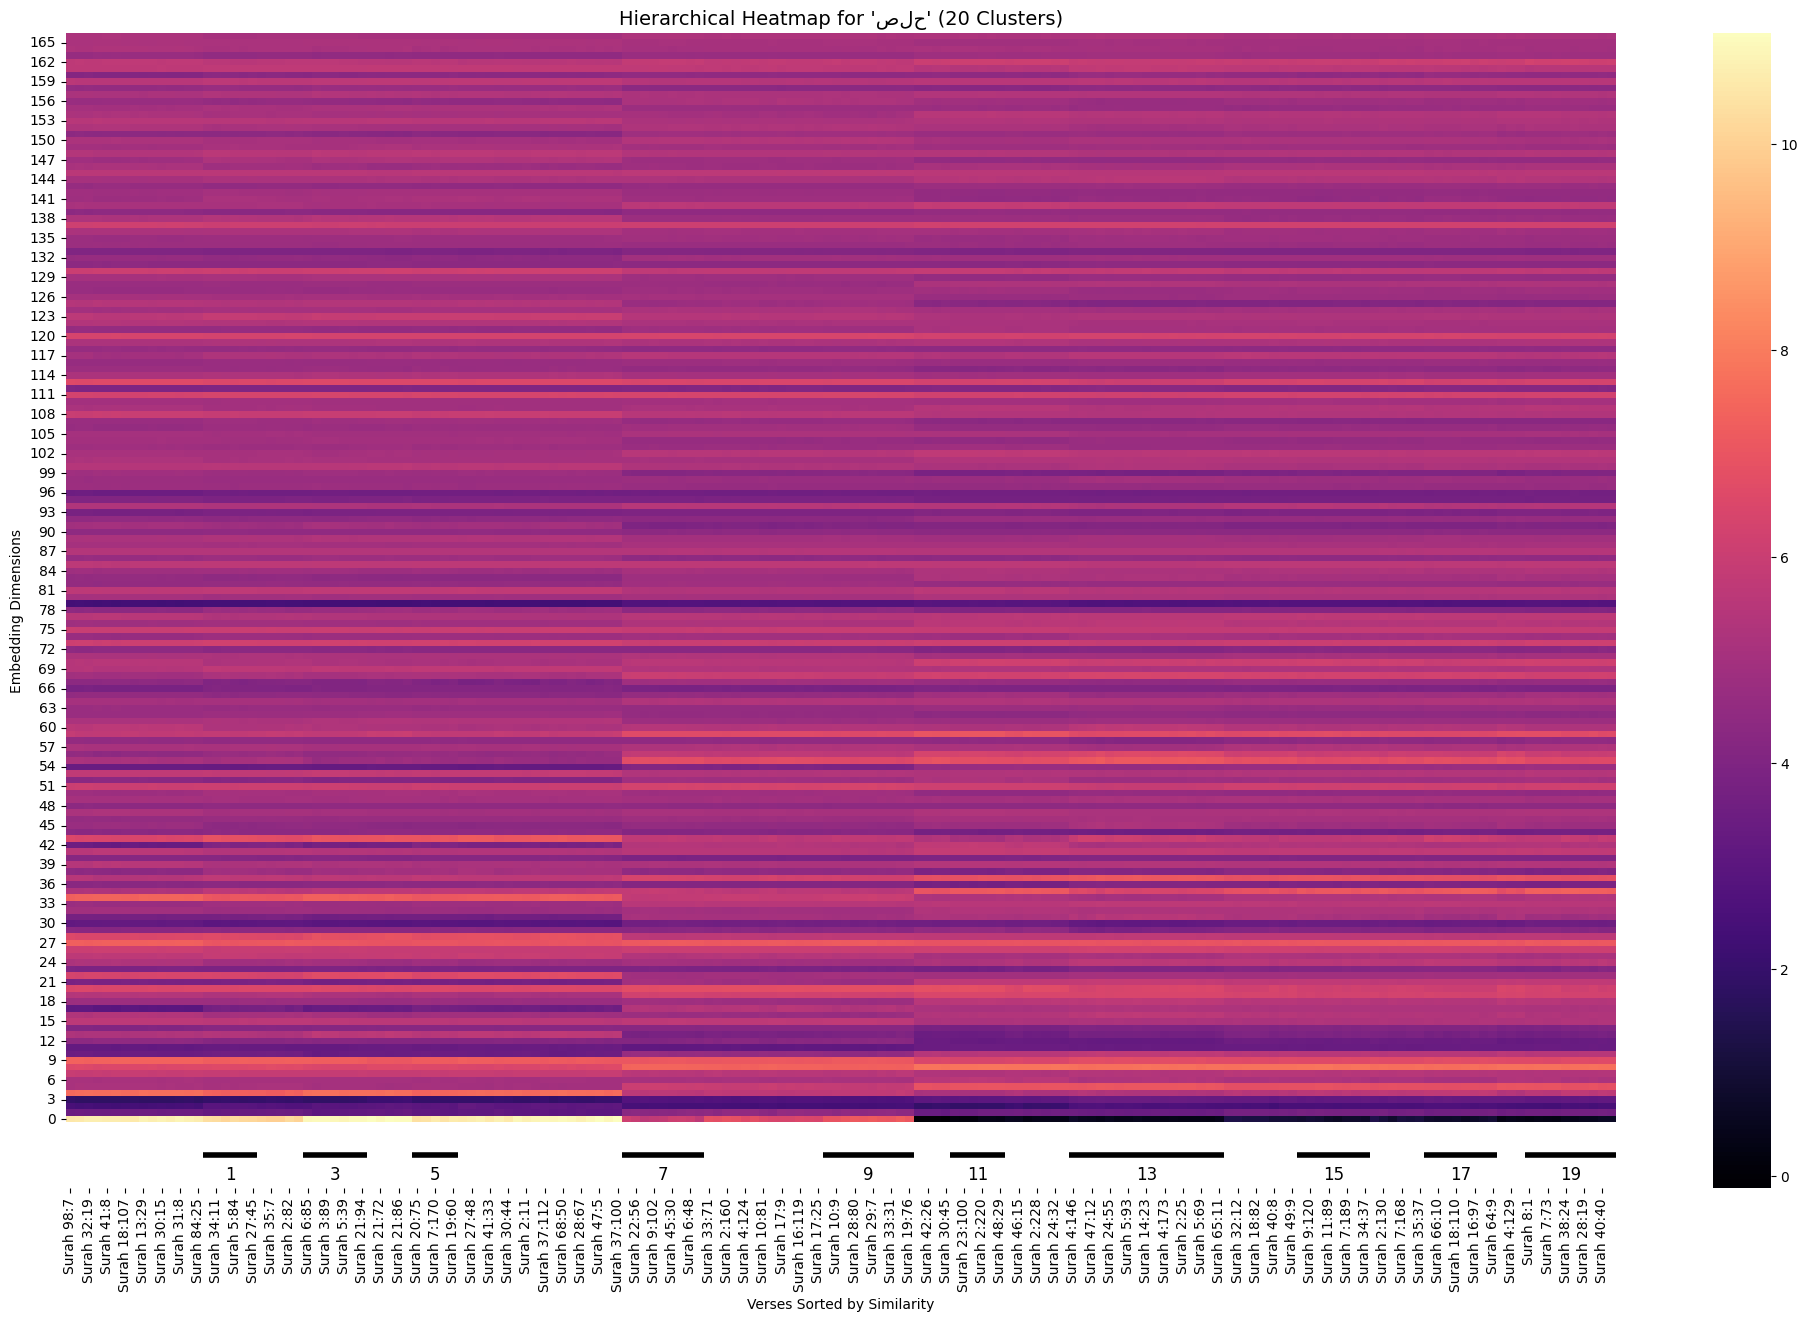

✅ Final heatmap saved to 'output/minilm/صلح_verses_hierarchical_heatmap.png'.
✅ Saved hierarchical clustering JSON output to 'output/minilm/صلح_verses_hierarchical_clusters.json'.
✅ Saved human-readable text output to 'output/minilm/صلح_verses-human_readable_clusters.txt'.


In [12]:
# Hierarchical Clustering

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy.cluster.hierarchy import linkage, fcluster, leaves_list

# --- Config ---
default_clusters = 10  # Default clustering value for initial visualization
heatmap_output = f"output/minilm/{specific_root}_verses_hierarchical_heatmap.png"
cluster_json_output = f"output/minilm/{specific_root}_verses_hierarchical_clusters.json"
txt_output_file = f"output/minilm/{specific_root}_verses-human_readable_clusters.txt"

# --- Load Reduced Embeddings ---
filtered_reduced_file = f"output/minilm/{specific_root}_sentence_MiniLM_reduced.pkl"
print(f"📥 Loading reduced data from '{filtered_reduced_file}'...")
filtered_df = pd.read_pickle(filtered_reduced_file)
print(f"✅ Loaded reduced data for {len(filtered_df)} verses.")

# Extract reduced embeddings as a NumPy array
embeddings_array = np.array(filtered_df['reduced_embedding'].tolist())
print(f"✅ Extracted embeddings array with shape: {embeddings_array.shape}")

# Create verse labels (e.g., "Surah 1:1", "Surah 1:2", etc.)
verse_labels = filtered_df.apply(lambda row: f"Surah {row['surah']}:{row['verse']}", axis=1).tolist()

# --- Hierarchical Clustering ---
linkage_matrix = linkage(embeddings_array, method='ward')
ordered_indices = leaves_list(linkage_matrix)

# Compute default cluster labels (for visual inspection)
cluster_labels_default = fcluster(linkage_matrix, default_clusters, criterion='maxclust')
sorted_labels_default = cluster_labels_default[ordered_indices]

# --- Reorder Everything Based on Clustering ---
sorted_embeddings = embeddings_array[ordered_indices]
sorted_verse_labels = [verse_labels[i] for i in ordered_indices]

# Prepare heatmap data so that verses are along the horizontal axis
# (Transpose so rows = dimensions, columns = verses)
heatmap_data = pd.DataFrame(sorted_embeddings.T, columns=sorted_verse_labels)

# --- Plot Heatmap with Default Clusters (for inspection) ---
plt.figure(figsize=(25, 15))
ax = sns.heatmap(heatmap_data, cmap="magma", cbar=True)
ax.set_title(f"Hierarchical Heatmap for '{specific_root}' (Default {default_clusters} Clusters)", fontsize=14)
ax.set_xlabel("Verses Sorted by Similarity")
ax.set_ylabel("Embedding Dimensions")

# Draw cluster boundaries for default clusters under the verses area
cluster_boundaries = []
prev_label = sorted_labels_default[0]
for i, label in enumerate(sorted_labels_default):
    if label != prev_label:
        cluster_boundaries.append(i)
        prev_label = label
cluster_boundaries.append(len(sorted_verse_labels))

line_colors = ["black", "white"]
for i in range(len(cluster_boundaries) - 1):
    start = cluster_boundaries[i]
    end = cluster_boundaries[i + 1]
    ax.hlines(-5, start, end, colors=line_colors[i % 2], linewidth=4)
    ax.text((start + end) / 2, -8, f"{i+1}", ha="center", va="center", fontsize=12, color=line_colors[i % 2])

ax.set_xlim([0, len(sorted_verse_labels)])
ax.set_ylim([-10, heatmap_data.shape[0]])
plt.show()
plt.close()

# --- Ask User for New Number of Clusters ---
user_input = input(f"Enter desired number of clusters based on the above visualization (press Enter to keep default of {default_clusters}): ")
if user_input.strip() == "":
    final_clusters = default_clusters
else:
    try:
        final_clusters = int(user_input)
    except ValueError:
        print(f"Invalid input. Using default value of {default_clusters}.")
        final_clusters = default_clusters

# --- Recompute Cluster Labels Using User-Defined Number ---
cluster_labels = fcluster(linkage_matrix, final_clusters, criterion='maxclust')
sorted_labels_final = cluster_labels[ordered_indices]

# --- Replot Final Heatmap with Updated Clusters ---
plt.figure(figsize=(25, 15))
ax = sns.heatmap(heatmap_data, cmap="magma", cbar=True)
ax.set_title(f"Hierarchical Heatmap for '{specific_root}' ({final_clusters} Clusters)", fontsize=14)
ax.set_xlabel("Verses Sorted by Similarity")
ax.set_ylabel("Embedding Dimensions")

# Draw updated cluster boundaries
cluster_boundaries = []
prev_label = sorted_labels_final[0]
for i, label in enumerate(sorted_labels_final):
    if label != prev_label:
        cluster_boundaries.append(i)
        prev_label = label
cluster_boundaries.append(len(sorted_verse_labels))

for i in range(len(cluster_boundaries) - 1):
    start = cluster_boundaries[i]
    end = cluster_boundaries[i + 1]
    ax.hlines(-5, start, end, colors=line_colors[i % 2], linewidth=4)
    ax.text((start + end) / 2, -8, f"{i+1}", ha="center", va="center", fontsize=12, color=line_colors[i % 2])

ax.set_xlim([0, len(sorted_verse_labels)])
ax.set_ylim([-10, heatmap_data.shape[0]])
plt.savefig(heatmap_output, dpi=600, bbox_inches="tight")
plt.show()
plt.close()
print(f"✅ Final heatmap saved to '{heatmap_output}'.")

# --- Save Human-Readable Cluster Assignments as JSON ---
# Reorder the filtered DataFrame based on the ordered indices
sorted_df = filtered_df.iloc[ordered_indices].copy()
sorted_df['cluster'] = sorted_labels_final

clusters_dict = {}
for cluster in sorted(set(sorted_labels_final)):
    clusters_dict[f"Cluster {cluster}"] = []
    cluster_rows = sorted_df[sorted_df['cluster'] == cluster]
    for _, row in cluster_rows.iterrows():
        clusters_dict[f"Cluster {cluster}"].append({
            "surah": row['surah'],
            "verse": row['verse'],
            "text": row['text']
        })

with open(cluster_json_output, "w", encoding="utf-8") as f:
    json.dump(clusters_dict, f, ensure_ascii=False, indent=4)
print(f"✅ Saved hierarchical clustering JSON output to '{cluster_json_output}'.")

# --- Save Human-Readable Cluster Assignments as Plain Text ---
with open(txt_output_file, "w", encoding="utf-8") as f:
    for cluster in sorted(set(sorted_labels_final)):
        f.write(f"Cluster {cluster}:\n")
        cluster_rows = sorted_df[sorted_df['cluster'] == cluster]
        for _, row in cluster_rows.iterrows():
            line = json.dumps({
                "surah": row['surah'],
                "verse": row['verse'],
                "text": row['text']
            }, ensure_ascii=False)
            f.write(line + "\n")
        f.write("\n")
print(f"✅ Saved human-readable text output to '{txt_output_file}'.")


In [13]:
# Decay Threshold

import torch
import torch.nn.functional as F
import pandas as pd

# Set the decay threshold value (adjust as needed)
DECAY_THRESHOLD = 0.7

# Load the filtered DataFrame with metadata and embeddings
filtered_df = pd.read_pickle(f"output/minilm/{specific_root}_sentence_MiniLM.pkl")

# Make sure the filtered DataFrame is sorted by surah and verse (optional but recommended)
filtered_df = filtered_df.sort_values(by=['surah', 'verse']).reset_index(drop=True)

# Extract embeddings and convert them to a tensor (if not already)
filtered_embeddings = torch.tensor(filtered_df['embedding'].tolist())

def get_context_for_anchor(anchor_idx, embeddings, threshold=DECAY_THRESHOLD):
    """
    For a given anchor verse (by index), this function checks the previous and next verses
    (in the filtered list) and includes them in the context as long as the cosine similarity
    between the anchor verse and the neighbor remains above the threshold.
    """
    anchor_emb = embeddings[anchor_idx]
    context_indices = [anchor_idx]
    
    # Look backward
    i = anchor_idx - 1
    while i >= 0:
        sim = F.cosine_similarity(anchor_emb.unsqueeze(0), embeddings[i].unsqueeze(0)).item()
        if sim >= threshold:
            context_indices.insert(0, i)  # Prepend to maintain order
        else:
            break
        i -= 1
    
    # Look forward
    i = anchor_idx + 1
    while i < len(embeddings):
        sim = F.cosine_similarity(anchor_emb.unsqueeze(0), embeddings[i].unsqueeze(0)).item()
        if sim >= threshold:
            context_indices.append(i)
        else:
            break
        i += 1
        
    return context_indices

# Prepare output lines for the first 20 examples
output_lines = []
num_examples = min(20, len(filtered_df))
for idx in range(num_examples):
    context_idx = get_context_for_anchor(idx, filtered_embeddings)
    output_lines.append(f"Anchor Verse (Index {idx}):")
    output_lines.append(filtered_df.iloc[idx]['text'])
    output_lines.append("Context Verses:")
    for i in context_idx:
        output_lines.append(f"  - (Index {i}) {filtered_df.iloc[i]['text']}")
    output_lines.append("\n" + "="*50 + "\n")

# Save the output to a text file for manual review
with open(f"output/minilm/{specific_root}_decay_MiniLM_threshold_context.txt", "w", encoding="utf-8") as f:
    for line in output_lines:
        f.write(line + "\n")

print(f"✅ Decay threshold context output saved to '{specific_root}_decay_MiniLM_threshold_context.txt'")


✅ Decay threshold context output saved to 'decay_MiniLM_threshold_context.txt'
